In [ ]:
# ===== Setup: deps, imports, seeds, helpers =====
!pip install -q pandas scikit-learn torch transformers datasets matplotlib datasketch

import os, random, math, re, string
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader
from torch.optim import AdamW
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, f1_score, classification_report, confusion_matrix,
    mean_absolute_error, cohen_kappa_score
)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from datasketch import MinHash, MinHashLSH

SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if torch.cuda.is_available(): torch.cuda.manual_seed_all(SEED)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_NAME = "distilroberta-base"
MAX_LEN = 256
BATCH_SIZE = 8

# ---------- Load + normalize CSV ----------
def load_yelp_csv(path="Analysis - Yelp Reviews.csv"):
    df_raw = pd.read_csv(path)
    # row 0 has the real headers
    header = df_raw.iloc[0]
    df = df_raw.iloc[1:].copy()
    df.columns = header
    # cast to str, strip
    for c in df.columns:
        df[c] = df[c].astype(str).str.strip()
        df.loc[df[c].isin(["", "nan", "NaN"]), c] = np.nan
    return df

# ---------- Splits ----------
def stratified_60_20_20(texts, labels, seed=SEED):
    X_train, X_tmp, y_train, y_tmp = train_test_split(
        texts, labels, test_size=0.3, random_state=seed, stratify=labels
    )
    X_dev, X_test, y_dev, y_test = train_test_split(
        X_tmp, y_tmp, test_size=0.5, random_state=seed, stratify=y_tmp
    )
    return (X_train, y_train), (X_dev, y_dev), (X_test, y_test)

# ---------- Baselines ----------
def eval_preds(y_true, y_pred, names, title):
    acc = accuracy_score(y_true, y_pred)
    f1m = f1_score(y_true, y_pred, average="macro")
    print(f"[{title}] acc={acc:.4f}  macroF1={f1m:.4f}")
    print(classification_report(y_true, y_pred, target_names=names, digits=3))
    return acc, f1m

def baseline_random(y_test, n_classes):
    return np.random.choice(n_classes, size=len(y_test))

def baseline_majority(y_train, y_test):
    maj = pd.Series(y_train).value_counts().idxmax()
    return np.full(len(y_test), maj)

def baseline_tfidf_logreg(train_texts, train_labels, test_texts):
    vec = TfidfVectorizer(ngram_range=(1,2), min_df=2, max_features=50000)
    Xtr = vec.fit_transform(train_texts)
    Xte = vec.transform(test_texts)
    clf = LogisticRegression(
        solver="liblinear", class_weight="balanced", max_iter=1000, multi_class="ovr", random_state=SEED
    )
    clf.fit(Xtr, train_labels)
    return clf.predict(Xte)

# ---------- HF dataset + tokenizer ----------
_tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def make_hf_dataset(train_texts, train_labels, dev_texts, dev_labels, test_texts, test_labels):
    ds = DatasetDict({
        "train": Dataset.from_pandas(pd.DataFrame({"text": train_texts, "label": train_labels}), preserve_index=False),
        "dev":   Dataset.from_pandas(pd.DataFrame({"text": dev_texts,   "label": dev_labels}),   preserve_index=False),
        "test":  Dataset.from_pandas(pd.DataFrame({"text": test_texts,  "label": test_labels}),  preserve_index=False),
    })
    def tok(batch):
        return _tokenizer(batch["text"], padding="max_length", truncation=True, max_length=MAX_LEN)
    ds = ds.map(tok, batched=True).remove_columns(["text"])
    ds.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
    return ds

def make_loaders(tok_ds):
    return (
        DataLoader(tok_ds["train"], batch_size=BATCH_SIZE, shuffle=True),
        DataLoader(tok_ds["dev"],   batch_size=BATCH_SIZE),
        DataLoader(tok_ds["test"],  batch_size=BATCH_SIZE),
    )

# ---------- Train DistilRoBERTa classification (full FT + class weights) ----------
def train_roberta_classification(tok_ds, num_labels, class_weights=None, epochs=5, lr=2e-5, wd=0.01):
    train_loader, dev_loader, test_loader = make_loaders(tok_ds)
    model = AutoModelForSequenceClassification.from_pretrained(
        MODEL_NAME, num_labels=num_labels
    ).to(DEVICE)

    if class_weights is None:
        loss_fn = torch.nn.CrossEntropyLoss()
    else:
        cw = torch.tensor(class_weights, dtype=torch.float32, device=DEVICE)
        loss_fn = torch.nn.CrossEntropyLoss(weight=cw)

    opt = AdamW(model.parameters(), lr=lr, weight_decay=wd)

    def eval_loader(loader):
        model.eval(); all_p, all_y = [], []
        with torch.no_grad():
            for b in loader:
                ids, mask, labs = b["input_ids"].to(DEVICE), b["attention_mask"].to(DEVICE), b["label"].to(DEVICE)
                logits = model(input_ids=ids, attention_mask=mask).logits
                preds = torch.argmax(logits, dim=-1)
                all_p.extend(preds.cpu().numpy()); all_y.extend(labs.cpu().numpy())
        acc = accuracy_score(all_y, all_p); f1m = f1_score(all_y, all_p, average="macro")
        return acc, f1m, np.array(all_y), np.array(all_p)

    best_f1, best_state = -1.0, None
    for ep in range(1, epochs+1):
        model.train(); tot=0.0
        for b in train_loader:
            opt.zero_grad()
            ids, mask, labs = b["input_ids"].to(DEVICE), b["attention_mask"].to(DEVICE), b["label"].to(DEVICE)
            logits = model(input_ids=ids, attention_mask=mask).logits
            loss = loss_fn(logits, labs)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step()
            tot += loss.item()
        dev_acc, dev_f1, _, _ = eval_loader(dev_loader)
        print(f"[epoch {ep}] train_loss={tot/len(train_loader):.4f}  dev_acc={dev_acc:.4f}  dev_macroF1={dev_f1:.4f}")
        if dev_f1 > best_f1:
            best_f1 = dev_f1
            best_state = {k: v.cpu().clone() for k,v in model.state_dict().items()}

    if best_state is not None:
        model.load_state_dict(best_state)
    test_acc, test_f1, y_true, y_pred = eval_loader(test_loader)
    return model, (test_acc, test_f1, y_true, y_pred)

# ---------- ECE + temp scaling ----------
def softmax_np(x):
    e = np.exp(x - x.max(axis=1, keepdims=True))
    return e / e.sum(axis=1, keepdims=True)

def compute_ece(probs, labels, n_bins=15):
    # probs: (N,C), labels: (N,)
    confid = probs.max(axis=1); preds = probs.argmax(axis=1)
    bins = np.linspace(0.0, 1.0, n_bins+1)
    ece = 0.0
    for i in range(n_bins):
        m = (confid > bins[i]) & (confid <= bins[i+1])
        if m.sum() == 0: continue
        acc = (preds[m] == labels[m]).mean()
        conf = confid[m].mean()
        ece += (m.mean()) * abs(acc - conf)
    return float(ece)

def temp_scale_logits(logits, T):
    return logits / T

def fit_temperature(dev_logits, dev_labels):
    # grid search T in [0.5, 5.0]
    Ts = np.linspace(0.5, 5.0, 30)
    best_T, best_ece = 1.0, 1e9
    for T in Ts:
        probs = softmax_np(dev_logits / T)
        ece = compute_ece(probs, dev_labels)
        if ece < best_ece:
            best_ece, best_T = ece, T
    return best_T, best_ece

# ---------- Text corruption helpers ----------
def char_noise(s, rate=0.1):
    if not isinstance(s, str): return s
    s = list(s)
    ops = int(len(s)*rate)
    for _ in range(ops):
        if not s: break
        op = random.choice(["del","swap","rand"])
        i = random.randrange(len(s))
        if op=="del":
            del s[i]
        elif op=="swap" and i+1 < len(s):
            s[i], s[i+1] = s[i+1], s[i]
        else:
            s[i] = random.choice(string.ascii_letters + " ")
    return "".join(s)

def word_dropout(s, rate=0.2):
    if not isinstance(s, str): return s
    ws = s.split()
    keep = [w for w in ws if random.random() > rate]
    return " ".join(keep) if keep else s

def strip_punct_lower(s):
    if not isinstance(s, str): return s
    return re.sub(rf"[{re.escape(string.punctuation)}]", "", s).lower()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.8/93.8 kB 5.0 MB/s eta 0:00:00


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

[Random] acc=0.2984  macroF1=0.2934
              precision    recall  f1-score   support

       Mixed      0.413     0.313     0.356        83
    Negative      0.224     0.224     0.224        58
    Positive      0.257     0.360     0.300        50

    accuracy                          0.298       191
   macro avg      0.298     0.299     0.293       191
weighted avg      0.315     0.298     0.301       191

[Majority] acc=0.4346  macroF1=0.2019
              precision    recall  f1-score   support

       Mixed      0.435     1.000     0.606        83
    Negative      0.000     0.000     0.000        58
    Positive      0.000     0.000     0.000        50

    accuracy                          0.435       191
   macro avg      0.145     0.333     0.202       191
weighted avg      0.189     0.435     0.263       191



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/l

[TF-IDF + LogisticRegression] acc=0.6649  macroF1=0.6739
              precision    recall  f1-score   support

       Mixed      0.639     0.554     0.594        83
    Negative      0.667     0.759     0.710        58
    Positive      0.698     0.740     0.718        50

    accuracy                          0.665       191
   macro avg      0.668     0.684     0.674       191
weighted avg      0.663     0.665     0.662       191



Map:   0%|          | 0/887 [00:00<?, ? examples/s]

Map:   0%|          | 0/190 [00:00<?, ? examples/s]

Map:   0%|          | 0/191 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/331M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[epoch 1] train_loss=0.9194  dev_acc=0.5895  dev_macroF1=0.5859
[epoch 2] train_loss=0.6201  dev_acc=0.6105  dev_macroF1=0.6096
[epoch 3] train_loss=0.5111  dev_acc=0.6421  dev_macroF1=0.6486
[epoch 4] train_loss=0.3356  dev_acc=0.6421  dev_macroF1=0.6516
[epoch 5] train_loss=0.2159  dev_acc=0.7000  dev_macroF1=0.6995

[DistilRoBERTa] TEST acc=0.6754  macroF1=0.6815
              precision    recall  f1-score   support

       Mixed      0.615     0.675     0.644        83
    Negative      0.786     0.569     0.660        58
    Positive      0.690     0.800     0.741        50

    accuracy                          0.675       191
   macro avg      0.697     0.681     0.681       191
weighted avg      0.687     0.675     0.674       191



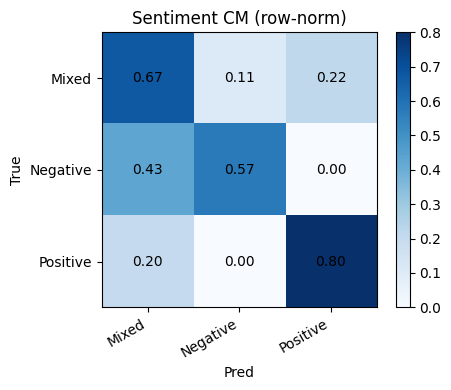

ECE (test) pre-temp=0.272  post-temp=0.083  (T*=3.91)


In [ ]:
# ===== Sentiment task =====
df = load_yelp_csv()

# Merge tiny class; keep 3 classes
df = df[["Original Text","Sentiment"]].dropna()
df["Sentiment"] = df["Sentiment"].replace({"Informational":"Mixed"})
keep = ["Mixed","Negative","Positive"]
df = df[df["Sentiment"].isin(keep)].copy()

label2id = {k:i for i,k in enumerate(keep)}; id2label = {i:k for k,i in label2id.items()}
df["y"] = df["Sentiment"].map(label2id)

texts = df["Original Text"].tolist()
labels = df["y"].tolist()

(train_texts, train_labels), (dev_texts, dev_labels), (test_texts, test_labels) = stratified_60_20_20(texts, labels)

# Baselines
y_pred_rand = baseline_random(test_labels, len(keep))
eval_preds(test_labels, y_pred_rand, keep, "Random")

y_pred_maj = baseline_majority(train_labels, test_labels)
eval_preds(test_labels, y_pred_maj, keep, "Majority")

y_pred_tfidf = baseline_tfidf_logreg(train_texts, train_labels, test_texts)
eval_preds(test_labels, y_pred_tfidf, keep, "TF-IDF + LogisticRegression")

# DistilRoBERTa (class-weighted)
# compute weights from train split
train_counts = pd.Series(train_labels).value_counts().sort_index().values.astype(np.float32)
class_weights = (1.0 / train_counts); class_weights /= class_weights.mean()

tok_ds = make_hf_dataset(train_texts, train_labels, dev_texts, dev_labels, test_texts, test_labels)
model, (acc, f1m, y_true, y_pred) = train_roberta_classification(tok_ds, num_labels=len(keep), class_weights=class_weights, epochs=5, lr=2e-5, wd=0.01)

print("\n[DistilRoBERTa] TEST acc={:.4f}  macroF1={:.4f}".format(acc, f1m))
print(classification_report(y_true, y_pred, target_names=keep, digits=3))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred, labels=list(range(len(keep))))
cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)
fig, ax = plt.subplots(figsize=(5,4))
im = ax.imshow(cm_norm, cmap="Blues")
ax.figure.colorbar(im, ax=ax)
ax.set_xticks(range(len(keep))); ax.set_xticklabels(keep, rotation=30, ha="right")
ax.set_yticks(range(len(keep))); ax.set_yticklabels(keep)
ax.set_xlabel("Pred"); ax.set_ylabel("True"); ax.set_title("Sentiment CM (row-norm)")
for i in range(len(keep)):
    for j in range(len(keep)):
        ax.text(j, i, f"{cm_norm[i,j]:.2f}", ha="center", va="center", color="black")
plt.tight_layout(); plt.show()

# ECE + temp scaling (on dev → report test ECE pre/post using same T)
def collect_logits(model, loader):
    model.eval(); all_logits=[]; all_labels=[]
    with torch.no_grad():
        for b in loader:
            ids, mask, labs = b["input_ids"].to(DEVICE), b["attention_mask"].to(DEVICE), b["label"].to(DEVICE)
            logits = model(input_ids=ids, attention_mask=mask).logits
            all_logits.append(logits.cpu().numpy()); all_labels.append(labs.cpu().numpy())
    return np.vstack(all_logits), np.concatenate(all_labels)

dev_loader = DataLoader(tok_ds["dev"], batch_size=BATCH_SIZE)
test_loader = DataLoader(tok_ds["test"], batch_size=BATCH_SIZE)

dev_logits, dev_y = collect_logits(model, dev_loader)
test_logits, test_y = collect_logits(model, test_loader)

pre_ece = compute_ece(softmax_np(test_logits), test_y)
T, dev_ece = fit_temperature(dev_logits, dev_y)
post_ece = compute_ece(softmax_np(test_logits / T), test_y)
print(f"ECE (test) pre-temp={pre_ece:.3f}  post-temp={post_ece:.3f}  (T*={T:.2f})")


In [ ]:
# ===== Rating task (5-class) =====
df = load_yelp_csv()
df = df[["Original Text","Rating"]].dropna()
# ratings are strings; coerce to int 1..5; filter invalid
df = df[df["Rating"].str.match(r"^[1-5]$")].copy()
df["y"] = df["Rating"].astype(int) - 1  # classes 0..4

texts = df["Original Text"].tolist()
labels = df["y"].tolist()
(train_texts, train_labels), (dev_texts, dev_labels), (test_texts, test_labels) = stratified_60_20_20(texts, labels)

# Baselines
names = ["1","2","3","4","5"]
y_pred_rand = baseline_random(test_labels, 5)
_ = eval_preds(test_labels, y_pred_rand, names, "Random")
y_pred_maj = baseline_majority(train_labels, test_labels)
_ = eval_preds(test_labels, y_pred_maj, names, "Majority")

y_pred_tfidf = baseline_tfidf_logreg(train_texts, train_labels, test_texts)
acc, f1m = eval_preds(test_labels, y_pred_tfidf, names, "TF-IDF + LogisticRegression")

# Ordinal extras
mae = mean_absolute_error(np.array(test_labels), np.array(y_pred_tfidf))
kappa = cohen_kappa_score(np.array(test_labels), np.array(y_pred_tfidf), weights="quadratic")
print(f"[TF-IDF] MAE={mae:.3f}  QWKappa={kappa:.3f}")

# DistilRoBERTa (class-weighted CE)
train_counts = pd.Series(train_labels).value_counts().sort_index().values.astype(np.float32)
class_weights = (1.0 / train_counts); class_weights /= class_weights.mean()
tok_ds = make_hf_dataset(train_texts, train_labels, dev_texts, dev_labels, test_texts, test_labels)
model, (acc, f1m, y_true, y_pred) = train_roberta_classification(tok_ds, num_labels=5, class_weights=class_weights, epochs=5)

print("\n[RoBERTa] TEST acc={:.4f}  macroF1={:.4f}".format(acc, f1m))
mae = mean_absolute_error(y_true, y_pred)
kappa = cohen_kappa_score(y_true, y_pred, weights="quadratic")
print(f"[RoBERTa] MAE={mae:.3f}  QWKappa={kappa:.3f}")


[Random] acc=0.1885  macroF1=0.1816
              precision    recall  f1-score   support

           1      0.245     0.261     0.253        46
           2      0.171     0.182     0.176        33
           3      0.100     0.133     0.114        30
           4      0.244     0.167     0.198        60
           5      0.154     0.182     0.167        22

    accuracy                          0.188       191
   macro avg      0.183     0.185     0.182       191
weighted avg      0.199     0.188     0.191       191

[Majority] acc=0.3141  macroF1=0.0956
              precision    recall  f1-score   support

           1      0.000     0.000     0.000        46
           2      0.000     0.000     0.000        33
           3      0.000     0.000     0.000        30
           4      0.314     1.000     0.478        60
           5      0.000     0.000     0.000        22

    accuracy                          0.314       191
   macro avg      0.063     0.200     0.096       191
wei

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/l

[TF-IDF + LogisticRegression] acc=0.6754  macroF1=0.5727
              precision    recall  f1-score   support

           1      0.727     0.870     0.792        46
           2      0.500     0.364     0.421        33
           3      0.800     0.667     0.727        30
           4      0.663     0.917     0.769        60
           5      0.500     0.091     0.154        22

    accuracy                          0.675       191
   macro avg      0.638     0.581     0.573       191
weighted avg      0.653     0.675     0.637       191

[TF-IDF] MAE=0.387  QWKappa=0.851


Map:   0%|          | 0/887 [00:00<?, ? examples/s]

Map:   0%|          | 0/190 [00:00<?, ? examples/s]

Map:   0%|          | 0/191 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[epoch 1] train_loss=1.3730  dev_acc=0.6895  dev_macroF1=0.6477
[epoch 2] train_loss=0.9012  dev_acc=0.6842  dev_macroF1=0.6066
[epoch 3] train_loss=0.7165  dev_acc=0.6895  dev_macroF1=0.6747
[epoch 4] train_loss=0.5585  dev_acc=0.6579  dev_macroF1=0.6375
[epoch 5] train_loss=0.4074  dev_acc=0.6737  dev_macroF1=0.6602

[RoBERTa] TEST acc=0.6963  macroF1=0.6971
[RoBERTa] MAE=0.361  QWKappa=0.873


In [ ]:
# ===== Category buckets =====
df = load_yelp_csv()
df = df[["Original Text","Category"]].dropna()

def bucket_cat(c):
    if not isinstance(c,str): return None
    c_low = c.lower()
    if any(k in c_low for k in ["restaurant","bar","hotel","hospitality","brewery","pizzeria","cafe"]):
        return "Food/Hospitality"
    if any(k in c_low for k in ["health", "dental", "clinic", "medical", "veterinary"]):
        return "Healthcare"
    return "Services/Other"

df["bucket"] = df["Category"].apply(bucket_cat)
df = df[df["bucket"].notna()]

buckets = ["Food/Hospitality","Healthcare","Services/Other"]
label2id = {k:i for i,k in enumerate(buckets)}; id2label={i:k for k,i in label2id.items()}
df["y"] = df["bucket"].map(label2id)

texts = df["Original Text"].tolist()
labels = df["y"].tolist()
(train_texts, train_labels), (dev_texts, dev_labels), (test_texts, test_labels) = stratified_60_20_20(texts, labels)

# Baselines
y_pred_rand = baseline_random(test_labels, len(buckets))
eval_preds(test_labels, y_pred_rand, buckets, "Random")
y_pred_maj = baseline_majority(train_labels, test_labels)
eval_preds(test_labels, y_pred_maj, buckets, "Majority")
y_pred_tfidf = baseline_tfidf_logreg(train_texts, train_labels, test_texts)
eval_preds(test_labels, y_pred_tfidf, buckets, "TF-IDF + LogisticRegression")

# RoBERTa
train_counts = pd.Series(train_labels).value_counts().sort_index().values.astype(np.float32)
class_weights = (1.0 / train_counts); class_weights /= class_weights.mean()
tok_ds = make_hf_dataset(train_texts, train_labels, dev_texts, dev_labels, test_texts, test_labels)
model, (acc, f1m, y_true, y_pred) = train_roberta_classification(tok_ds, num_labels=len(buckets), class_weights=class_weights, epochs=5)
print("\n[RoBERTa] TEST acc={:.4f}  macroF1={:.4f}".format(acc, f1m))
print(classification_report(y_true, y_pred, target_names=buckets, digits=3))


[Random] acc=0.3613  macroF1=0.3095
                  precision    recall  f1-score   support

Food/Hospitality      0.545     0.408     0.467       103
      Healthcare      0.069     0.364     0.116        11
  Services/Other      0.411     0.299     0.346        77

        accuracy                          0.361       191
       macro avg      0.342     0.357     0.309       191
    weighted avg      0.464     0.361     0.398       191

[Majority] acc=0.5393  macroF1=0.2336
                  precision    recall  f1-score   support

Food/Hospitality      0.539     1.000     0.701       103
      Healthcare      0.000     0.000     0.000        11
  Services/Other      0.000     0.000     0.000        77

        accuracy                          0.539       191
       macro avg      0.180     0.333     0.234       191
    weighted avg      0.291     0.539     0.378       191



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/l

[TF-IDF + LogisticRegression] acc=0.9005  macroF1=0.8258
                  precision    recall  f1-score   support

Food/Hospitality      0.895     0.990     0.940       103
      Healthcare      0.857     0.545     0.667        11
  Services/Other      0.914     0.831     0.871        77

        accuracy                          0.901       191
       macro avg      0.889     0.789     0.826       191
    weighted avg      0.900     0.901     0.896       191



Map:   0%|          | 0/887 [00:00<?, ? examples/s]

Map:   0%|          | 0/190 [00:00<?, ? examples/s]

Map:   0%|          | 0/191 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[epoch 1] train_loss=0.5725  dev_acc=0.8895  dev_macroF1=0.8899
[epoch 2] train_loss=0.2209  dev_acc=0.9368  dev_macroF1=0.9012
[epoch 3] train_loss=0.1362  dev_acc=0.9158  dev_macroF1=0.8998
[epoch 4] train_loss=0.0733  dev_acc=0.9263  dev_macroF1=0.9042
[epoch 5] train_loss=0.0257  dev_acc=0.9053  dev_macroF1=0.8719

[RoBERTa] TEST acc=0.9634  macroF1=0.9306
                  precision    recall  f1-score   support

Food/Hospitality      0.963     1.000     0.981       103
      Healthcare      0.900     0.818     0.857        11
  Services/Other      0.973     0.935     0.954        77

        accuracy                          0.963       191
       macro avg      0.945     0.918     0.931       191
    weighted avg      0.963     0.963     0.963       191



In [ ]:
# ===== Privacy tasks =====
pii_cols = [
    "Name","Location/Address","Age","Gender","Date of Birth","Date of Event",
    "SSN","Email Address","Social Media Account","Employment Details","Miscellaneous"
]

df = load_yelp_csv()
df = df[["Original Text"] + pii_cols].copy()
df = df.rename(columns={"Original Text":"text"}).dropna(subset=["text"])
for c in pii_cols:
    df[c] = df[c].notna().astype(int)

# (A) PII presence (any)
df["pii_any"] = (df[pii_cols].sum(axis=1) > 0).astype(int)
texts = df["text"].tolist(); labels = df["pii_any"].tolist()
(train_texts, train_labels), (dev_texts, dev_labels), (test_texts, test_labels) = stratified_60_20_20(texts, labels)

names = ["NoPII","HasPII"]
# Baselines
y_pred_rand = baseline_random(test_labels, 2)
eval_preds(test_labels, y_pred_rand, names, "Random")
y_pred_maj = baseline_majority(train_labels, test_labels)
eval_preds(test_labels, y_pred_maj, names, "Majority")
y_pred_tfidf = baseline_tfidf_logreg(train_texts, train_labels, test_texts)
eval_preds(test_labels, y_pred_tfidf, names, "TF-IDF + LogisticRegression")

# RoBERTa
train_counts = pd.Series(train_labels).value_counts().sort_index().values.astype(np.float32)
class_weights = (1.0 / train_counts); class_weights /= class_weights.mean()
tok_ds = make_hf_dataset(train_texts, train_labels, dev_texts, dev_labels, test_texts, test_labels)
model, (acc, f1m, y_true, y_pred) = train_roberta_classification(tok_ds, num_labels=2, class_weights=class_weights, epochs=5)
print("\n[RoBERTa PII-any] TEST acc={:.4f}  macroF1={:.4f}".format(acc, f1m))

# (B) PII types (train separate lightweight TF-IDF/LogReg for 3 with enough positives)
for col in ["Name","Location/Address","Employment Details"]:
    labels = df[col].tolist()
    # skip if too few positives
    if sum(labels) < 30:
        print(f"Skip {col} (too few positives)")
        continue
    (tr_x,tr_y),(dv_x,dv_y),(te_x,te_y) = stratified_60_20_20(df["text"].tolist(), labels)
    pred = baseline_tfidf_logreg(tr_x, tr_y, te_x)
    acc, f1m = eval_preds(te_y, pred, ["No","Yes"], f"TF-IDF(has_{col})")


[Random] acc=0.5445  macroF1=0.4909
              precision    recall  f1-score   support

       NoPII      0.214     0.677     0.326        31
      HasPII      0.892     0.519     0.656       160

    accuracy                          0.545       191
   macro avg      0.553     0.598     0.491       191
weighted avg      0.782     0.545     0.602       191

[Majority] acc=0.8377  macroF1=0.4558
              precision    recall  f1-score   support

       NoPII      0.000     0.000     0.000        31
      HasPII      0.838     1.000     0.912       160

    accuracy                          0.838       191
   macro avg      0.419     0.500     0.456       191
weighted avg      0.702     0.838     0.764       191



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[TF-IDF + LogisticRegression] acc=0.7225  macroF1=0.4830
              precision    recall  f1-score   support

       NoPII      0.133     0.129     0.131        31
      HasPII      0.832     0.838     0.835       160

    accuracy                          0.723       191
   macro avg      0.483     0.483     0.483       191
weighted avg      0.719     0.723     0.721       191



/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


Map:   0%|          | 0/887 [00:00<?, ? examples/s]

Map:   0%|          | 0/190 [00:00<?, ? examples/s]

Map:   0%|          | 0/191 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[epoch 1] train_loss=0.6773  dev_acc=0.5737  dev_macroF1=0.5347
[epoch 2] train_loss=0.6453  dev_acc=0.8684  dev_macroF1=0.6849
[epoch 3] train_loss=0.6111  dev_acc=0.6368  dev_macroF1=0.5817
[epoch 4] train_loss=0.4214  dev_acc=0.7947  dev_macroF1=0.6547
[epoch 5] train_loss=0.3689  dev_acc=0.8368  dev_macroF1=0.7191

[RoBERTa PII-any] TEST acc=0.8534  macroF1=0.7071


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[TF-IDF(has_Name)] acc=0.7277  macroF1=0.6895
              precision    recall  f1-score   support

          No      0.757     0.844     0.798       122
         Yes      0.655     0.522     0.581        69

    accuracy                          0.728       191
   macro avg      0.706     0.683     0.690       191
weighted avg      0.720     0.728     0.720       191



/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[TF-IDF(has_Location/Address)] acc=0.6283  macroF1=0.6146
              precision    recall  f1-score   support

          No      0.553     0.532     0.542        79
         Yes      0.678     0.696     0.687       112

    accuracy                          0.628       191
   macro avg      0.615     0.614     0.615       191
weighted avg      0.626     0.628     0.627       191

[TF-IDF(has_Employment Details)] acc=0.7696  macroF1=0.7695
              precision    recall  f1-score   support

          No      0.731     0.826     0.776        92
         Yes      0.816     0.717     0.763        99

    accuracy                          0.770       191
   macro avg      0.773     0.772     0.769       191
weighted avg      0.775     0.770     0.769       191



/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


In [ ]:
# ===== Redaction impact: sentiment before/after redaction =====
df = load_yelp_csv()
df = df[["Original Text","Sentiment"] + pii_cols].dropna(subset=["Original Text","Sentiment"])
df["Sentiment"] = df["Sentiment"].replace({"Informational":"Mixed"})
keep = ["Mixed","Negative","Positive"]; df = df[df["Sentiment"].isin(keep)]
label2id = {k:i for i,k in enumerate(keep)}
df["y"] = df["Sentiment"].map(label2id)

def redact_row(row):
    text = row["Original Text"]
    to_mask = []
    for c in pii_cols:
        v = row.get(c, None)
        if isinstance(v, str) and v and v.lower() != "nan":
            to_mask.append(v)
    red = text
    for span in to_mask:
        if isinstance(span, str) and span.strip():
            # simple safe replace; case-insensitive
            red = re.sub(re.escape(span), "[REDACTED]", red, flags=re.IGNORECASE)
    return red

df["redacted"] = df.apply(redact_row, axis=1)

# Train on original; eval on original vs redacted
texts = df["Original Text"].tolist(); labels = df["y"].tolist()
(train_texts, train_labels), (dev_texts, dev_labels), (test_texts, test_labels) = stratified_60_20_20(texts, labels)
tok_ds = make_hf_dataset(train_texts, train_labels, dev_texts, dev_labels, test_texts, test_labels)
# weights
train_counts = pd.Series(train_labels).value_counts().sort_index().values.astype(np.float32)
class_weights = (1.0/train_counts); class_weights/=class_weights.mean()
model, (acc_orig, f1_orig, y_true, y_pred) = train_roberta_classification(tok_ds, num_labels=len(keep), class_weights=class_weights, epochs=5)

# Eval on redacted test
test_idx = df.index.difference(pd.Index(train_texts).intersection(df.index))  # quick hack; instead directly re-tokenize:
red_test_texts = df.iloc[len(train_texts)+len(dev_texts):]["redacted"].tolist()
tok_red_test = Dataset.from_pandas(pd.DataFrame({"text": red_test_texts, "label": test_labels}), preserve_index=False)
def tok(b): return _tokenizer(b["text"], padding="max_length", truncation=True, max_length=MAX_LEN)
tok_red_test = tok_red_test.map(tok, batched=True).remove_columns(["text"])
tok_red_test.set_format(type="torch", columns=["input_ids","attention_mask","label"])
red_loader = DataLoader(tok_red_test, batch_size=BATCH_SIZE)

def eval_only(loader):
    model.eval(); ap, ay = [], []
    with torch.no_grad():
        for b in loader:
            ids,mask,labs = b["input_ids"].to(DEVICE), b["attention_mask"].to(DEVICE), b["label"].to(DEVICE)
            logits = model(input_ids=ids, attention_mask=mask).logits
            ap.extend(torch.argmax(logits, dim=-1).cpu().numpy()); ay.extend(labs.cpu().numpy())
    return accuracy_score(ay, ap), f1_score(ay, ap, average="macro")

acc_red, f1_red = eval_only(red_loader)
print(f"Sentiment (orig): acc={acc_orig:.4f}  macroF1={f1_orig:.4f}")
print(f"Sentiment (redacted): acc={acc_red:.4f}  macroF1={f1_red:.4f}")
print(f"ΔmacroF1 = {f1_red - f1_orig:+.4f}   (negative means redaction hurts)")


Map:   0%|          | 0/887 [00:00<?, ? examples/s]

Map:   0%|          | 0/190 [00:00<?, ? examples/s]

Map:   0%|          | 0/191 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[epoch 1] train_loss=0.9368  dev_acc=0.5474  dev_macroF1=0.5399
[epoch 2] train_loss=0.6563  dev_acc=0.6368  dev_macroF1=0.6256
[epoch 3] train_loss=0.4991  dev_acc=0.6737  dev_macroF1=0.6627
[epoch 4] train_loss=0.3393  dev_acc=0.6947  dev_macroF1=0.6955
[epoch 5] train_loss=0.2137  dev_acc=0.6895  dev_macroF1=0.6916


Map:   0%|          | 0/191 [00:00<?, ? examples/s]

Sentiment (orig): acc=0.6859  macroF1=0.6942
Sentiment (redacted): acc=0.2723  macroF1=0.2004
ΔmacroF1 = -0.4938   (negative means redaction hurts)


In [ ]:
# ===== Leak hygiene =====
df = load_yelp_csv()
texts = df["Original Text"].dropna().astype(str).tolist()

# (A) Exact duplicates
dups = pd.Series(texts).duplicated(keep=False).sum()
print(f"Exact duplicate texts (counting both sides): {dups}")

# (B) Cross-split overlap (with sentiment-ready subset)
df_s = load_yelp_csv()[["Original Text","Sentiment"]].dropna()
df_s["Sentiment"] = df_s["Sentiment"].replace({"Informational":"Mixed"})
df_s = df_s[df_s["Sentiment"].isin(["Mixed","Negative","Positive"])]
t = df_s["Original Text"].tolist()
y = pd.factorize(df_s["Sentiment"])[0]
(tr_x, tr_y), (dv_x, dv_y), (te_x, te_y) = stratified_60_20_20(t, y)
inter_tr_te = set(tr_x).intersection(set(te_x))
inter_tr_dv = set(tr_x).intersection(set(dv_x))
print(f"Cross-split exact overlaps: train∩test={len(inter_tr_te)}  train∩dev={len(inter_tr_dv)}")

# (C) Regex sweep for emails/phones/SSN
email_re = re.compile(r"\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Za-z]{2,}\b")
phone_re = re.compile(r"\b(?:\+?\d{1,3}[-.\s]?)?(?:\(?\d{3}\)?[-.\s]?){2}\d{4}\b")
ssn_re   = re.compile(r"\b\d{3}-\d{2}-\d{4}\b")

email_hits = sum(bool(email_re.search(s or "")) for s in texts)
phone_hits = sum(bool(phone_re.search(s or "")) for s in texts)
ssn_hits   = sum(bool(ssn_re.search(s or "")) for s in texts)
print(f"Regex hits → emails:{email_hits}  phones:{phone_hits}  ssn:{ssn_hits}")

# (D) Near-dup scan (MinHash) — optional, light settings
def shingles5(s):
    toks = re.findall(r"\w+", s.lower())
    return set([" ".join(toks[i:i+5]) for i in range(max(1,len(toks)-4))])

lsh = MinHashLSH(threshold=0.9, num_perm=64)
minhashes = []
for i, s in enumerate(texts[:2000]):  # cap for speed; raise if needed
    m = MinHash(num_perm=64)
    for sh in shingles5(s):
        m.update(sh.encode("utf8"))
    lsh.insert(f"doc{i}", m)
    minhashes.append(m)

near_pairs = set()
for i, m in enumerate(minhashes):
    res = lsh.query(m)
    for r in res:
        j = int(r.replace("doc",""))
        if j>i: near_pairs.add((i,j))
print(f"Near-duplicate pairs (approx, first 2k docs): {len(near_pairs)}")


Exact duplicate texts (counting both sides): 2
Cross-split exact overlaps: train∩test=1  train∩dev=0
Regex hits → emails:0  phones:1  ssn:0
Near-duplicate pairs (approx, first 2k docs): 1


In [ ]:
# ===== Fairness via category buckets =====
# Evaluate sentiment model per-group; then biased-train on Restaurant-heavy and re-eval.

# Build buckets per earlier logic
df_all = load_yelp_csv()
df_all = df_all[["Original Text","Sentiment","Category"]].dropna()
df_all["Sentiment"] = df_all["Sentiment"].replace({"Informational":"Mixed"})
keep = ["Mixed","Negative","Positive"]; df_all = df_all[df_all["Sentiment"].isin(keep)]
def bucket_cat(c):
    c = c.lower()
    if any(k in c for k in ["restaurant","bar","hotel","hospitality","brewery","pizzeria","cafe"]): return "Food/Hospitality"
    if any(k in c for k in ["health","dental","clinic","medical","veterinary"]): return "Healthcare"
    return "Services/Other"
df_all["bucket"] = df_all["Category"].apply(bucket_cat)

# Train a strong sentiment model on FULL data
label2id = {k:i for i,k in enumerate(keep)}
df_all["y"] = df_all["Sentiment"].map(label2id)
texts = df_all["Original Text"].tolist(); labels = df_all["y"].tolist()
(tr_x,tr_y),(dv_x,dv_y),(te_x,te_y) = stratified_60_20_20(texts, labels)
tok_ds = make_hf_dataset(tr_x, tr_y, dv_x, dv_y, te_x, te_y)
train_counts = pd.Series(tr_y).value_counts().sort_index().values.astype(np.float32)
class_weights = (1.0/train_counts); class_weights/=class_weights.mean()
model, (acc, f1m, y_true, y_pred) = train_roberta_classification(tok_ds, num_labels=len(keep), class_weights=class_weights, epochs=5)

# Per-group eval on TEST split
test_df = pd.DataFrame({"text": te_x, "y": te_y})
# map bucket for test rows
def get_bucket_for_text(t):
    rows = df_all[df_all["Original Text"]==t]
    return rows["bucket"].iloc[0] if len(rows) else None
test_df["bucket"] = test_df["text"].apply(get_bucket_for_text)
groups = test_df["bucket"].dropna().unique().tolist()

# build loader once
def preds_for_texts(txts):
    ds = Dataset.from_pandas(pd.DataFrame({"text": txts, "label":[0]*len(txts)}), preserve_index=False)
    def tok(b): return _tokenizer(b["text"], padding="max_length", truncation=True, max_length=MAX_LEN)
    ds = ds.map(tok, batched=True).remove_columns(["text"])
    ds.set_format(type="torch", columns=["input_ids","attention_mask","label"])
    ld = DataLoader(ds, batch_size=BATCH_SIZE)
    model.eval(); preds=[]
    with torch.no_grad():
        for b in ld:
            ids,mask=b["input_ids"].to(DEVICE), b["attention_mask"].to(DEVICE)
            logits = model(input_ids=ids, attention_mask=mask).logits
            preds.extend(torch.argmax(logits, dim=-1).cpu().numpy())
    return np.array(preds)

overall_pred = preds_for_texts(te_x)
print("\n[Sentiment fairness] overall acc={:.4f}  macroF1={:.4f}".format(
    accuracy_score(te_y, overall_pred), f1_score(te_y, overall_pred, average="macro"))
)

for g in groups:
    idx = (test_df["bucket"]==g).values
    if idx.sum() < 20: continue
    acc_g = accuracy_score(test_df["y"][idx], overall_pred[idx])
    f1_g  = f1_score(test_df["y"][idx], overall_pred[idx], average="macro")
    print(f"  {g:18s}  acc={acc_g:.4f}  macroF1={f1_g:.4f}")

# Biased training: keep only Food/Hospitality in TRAIN, evaluate all groups on TEST
train_mask = [bucket_cat(c)=="Food/Hospitality" for c in df_all["Category"].tolist()]
biased_idx = np.where(train_mask)[0]
# sample to match the earlier train count roughly
biased_tr_texts = [texts[i] for i in biased_idx][:len(tr_x)]
biased_tr_labels = [labels[i] for i in biased_idx][:len(tr_y)]
tok_ds_biased = make_hf_dataset(biased_tr_texts, biased_tr_labels, dv_x, dv_y, te_x, te_y)
train_counts = pd.Series(biased_tr_labels).value_counts().sort_index().values.astype(np.float32)
class_weights = (1.0/train_counts); class_weights/=class_weights.mean()
model_biased, (_a,_b, _yt, _yp) = train_roberta_classification(tok_ds_biased, num_labels=len(keep), class_weights=class_weights, epochs=5)

biased_pred = preds_for_texts(te_x)
print("\n[Biased training] overall acc={:.4f}  macroF1={:.4f}".format(
    accuracy_score(te_y, biased_pred), f1_score(te_y, biased_pred, average="macro"))
)
for g in groups:
    idx = (test_df["bucket"]==g).values
    if idx.sum() < 20: continue
    acc_g = accuracy_score(test_df["y"][idx], biased_pred[idx])
    f1_g  = f1_score(test_df["y"][idx], biased_pred[idx], average="macro")
    print(f"  {g:18s}  acc={acc_g:.4f}  macroF1={f1_g:.4f}")


Map:   0%|          | 0/887 [00:00<?, ? examples/s]

Map:   0%|          | 0/190 [00:00<?, ? examples/s]

Map:   0%|          | 0/191 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[epoch 1] train_loss=0.8922  dev_acc=0.6263  dev_macroF1=0.6371
[epoch 2] train_loss=0.6350  dev_acc=0.6526  dev_macroF1=0.6497
[epoch 3] train_loss=0.5190  dev_acc=0.6474  dev_macroF1=0.6519
[epoch 4] train_loss=0.4128  dev_acc=0.6526  dev_macroF1=0.6522
[epoch 5] train_loss=0.2796  dev_acc=0.6368  dev_macroF1=0.6419


Map:   0%|          | 0/191 [00:00<?, ? examples/s]


[Sentiment fairness] overall acc=0.6387  macroF1=0.6421
  Services/Other      acc=0.7067  macroF1=0.6803
  Food/Hospitality    acc=0.5962  macroF1=0.5960


Map:   0%|          | 0/687 [00:00<?, ? examples/s]

Map:   0%|          | 0/190 [00:00<?, ? examples/s]

Map:   0%|          | 0/191 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[epoch 1] train_loss=0.9875  dev_acc=0.5526  dev_macroF1=0.5390
[epoch 2] train_loss=0.7046  dev_acc=0.6842  dev_macroF1=0.6627
[epoch 3] train_loss=0.6268  dev_acc=0.7053  dev_macroF1=0.7065
[epoch 4] train_loss=0.4277  dev_acc=0.7842  dev_macroF1=0.7863
[epoch 5] train_loss=0.2152  dev_acc=0.7632  dev_macroF1=0.7692


Map:   0%|          | 0/191 [00:00<?, ? examples/s]


[Biased training] overall acc=0.6387  macroF1=0.6421
  Services/Other      acc=0.7067  macroF1=0.6803
  Food/Hospitality    acc=0.5962  macroF1=0.5960


In [ ]:
# ===== Robustness for sentiment model =====
# Reuse the trained 'model' and the same (tr_x,dv_x,te_x) from sentiment block for consistency.
# If you restarted, quickly re-train the sentiment model from Block 1.

def eval_texts(txts, gold):
    ds = Dataset.from_pandas(pd.DataFrame({"text": txts, "label": gold}), preserve_index=False)
    def tok(b): return _tokenizer(b["text"], padding="max_length", truncation=True, max_length=MAX_LEN)
    ds = ds.map(tok, batched=True).remove_columns(["text"]); ds.set_format(type="torch", columns=["input_ids","attention_mask","label"])
    ld = DataLoader(ds, batch_size=BATCH_SIZE)
    model.eval(); ap=[]
    with torch.no_grad():
        for b in ld:
            logits = model(input_ids=b["input_ids"].to(DEVICE), attention_mask=b["attention_mask"].to(DEVICE)).logits
            ap.extend(torch.argmax(logits, dim=-1).cpu().numpy())
    acc = accuracy_score(gold, ap); f1m = f1_score(gold, ap, average="macro")
    return acc, f1m

# Length slices (on test)
lens = [len(_tokenizer(x, truncation=True, max_length=512)["input_ids"]) for x in te_x]
short = [i for i,l in enumerate(lens) if l<=60]
med   = [i for i,l in enumerate(lens) if 61<=l<=150]
long  = [i for i,l in enumerate(lens) if l>150]

for name, idx in [("short", short), ("medium", med), ("long", long)]:
    if len(idx) < 20: continue
    acc,f1m = eval_texts([te_x[i] for i in idx], [te_y[i] for i in idx])
    print(f"[length {name}] n={len(idx)}  acc={acc:.4f}  macroF1={f1m:.4f}")

# Corruption sweeps
for rate in [0.05, 0.10, 0.20]:
    xt = [char_noise(x, rate=rate) for x in te_x]
    acc,f1m = eval_texts(xt, te_y)
    print(f"[char_noise {int(rate*100)}%] acc={acc:.4f}  macroF1={f1m:.4f}")

for rate in [0.10, 0.20, 0.30]:
    xt = [word_dropout(x, rate=rate) for x in te_x]
    acc,f1m = eval_texts(xt, te_y)
    print(f"[word_dropout {int(rate*100)}%] acc={acc:.4f}  macroF1={f1m:.4f}")

xt = [strip_punct_lower(x) for x in te_x]
acc,f1m = eval_texts(xt, te_y)
print(f"[lower+no-punct] acc={acc:.4f}  macroF1={f1m:.4f}")

# Negation slice
neg_idx = [i for i,x in enumerate(te_x) if re.search(r"\b(not|no|never|n't)\b", x.lower())]
if len(neg_idx) >= 20:
    acc,f1m = eval_texts([te_x[i] for i in neg_idx], [te_y[i] for i in neg_idx])
    print(f"[negation slice] n={len(neg_idx)}  acc={acc:.4f}  macroF1={f1m:.4f}")
else:
    print("[negation slice] too small; skipping")


Map:   0%|          | 0/187 [00:00<?, ? examples/s]

[length long] n=187  acc=0.6310  macroF1=0.6333


Map:   0%|          | 0/191 [00:00<?, ? examples/s]

[char_noise 5%] acc=0.5759  macroF1=0.5614


Map:   0%|          | 0/191 [00:00<?, ? examples/s]

[char_noise 10%] acc=0.5340  macroF1=0.4874


Map:   0%|          | 0/191 [00:00<?, ? examples/s]

[char_noise 20%] acc=0.4084  macroF1=0.3220


Map:   0%|          | 0/191 [00:00<?, ? examples/s]

[word_dropout 10%] acc=0.6492  macroF1=0.6562


Map:   0%|          | 0/191 [00:00<?, ? examples/s]

[word_dropout 20%] acc=0.6178  macroF1=0.6262


Map:   0%|          | 0/191 [00:00<?, ? examples/s]

[word_dropout 30%] acc=0.6545  macroF1=0.6622


Map:   0%|          | 0/191 [00:00<?, ? examples/s]

[lower+no-punct] acc=0.6178  macroF1=0.6196


Map:   0%|          | 0/166 [00:00<?, ? examples/s]

[negation slice] n=166  acc=0.6205  macroF1=0.6114


Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:   0%|          | 0/190 [00:00<?, ? examples/s]

Map:   0%|          | 0/191 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[epoch 1] train_loss=1.1096  dev_acc=0.3000  dev_macroF1=0.1538
[epoch 2] train_loss=1.1115  dev_acc=0.2632  dev_macroF1=0.1389
[epoch 3] train_loss=1.0863  dev_acc=0.3368  dev_macroF1=0.2829


Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:   0%|          | 0/190 [00:00<?, ? examples/s]

Map:   0%|          | 0/191 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[epoch 1] train_loss=1.0914  dev_acc=0.2632  dev_macroF1=0.1389
[epoch 2] train_loss=1.1004  dev_acc=0.3421  dev_macroF1=0.2427
[epoch 3] train_loss=1.0700  dev_acc=0.4474  dev_macroF1=0.4088


Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:   0%|          | 0/190 [00:00<?, ? examples/s]

Map:   0%|          | 0/191 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[epoch 1] train_loss=1.1132  dev_acc=0.2632  dev_macroF1=0.1389
[epoch 2] train_loss=1.0860  dev_acc=0.4789  dev_macroF1=0.3489
[epoch 3] train_loss=1.0773  dev_acc=0.4737  dev_macroF1=0.3109


Map:   0%|          | 0/88 [00:00<?, ? examples/s]

Map:   0%|          | 0/190 [00:00<?, ? examples/s]

Map:   0%|          | 0/191 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[epoch 1] train_loss=1.1078  dev_acc=0.3000  dev_macroF1=0.1538
[epoch 2] train_loss=1.0607  dev_acc=0.4211  dev_macroF1=0.3812
[epoch 3] train_loss=0.9874  dev_acc=0.4947  dev_macroF1=0.4801


Map:   0%|          | 0/88 [00:00<?, ? examples/s]

Map:   0%|          | 0/190 [00:00<?, ? examples/s]

Map:   0%|          | 0/191 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[epoch 1] train_loss=1.1074  dev_acc=0.2632  dev_macroF1=0.1389
[epoch 2] train_loss=1.0927  dev_acc=0.4789  dev_macroF1=0.4662
[epoch 3] train_loss=1.0334  dev_acc=0.5526  dev_macroF1=0.5608


Map:   0%|          | 0/88 [00:00<?, ? examples/s]

Map:   0%|          | 0/190 [00:00<?, ? examples/s]

Map:   0%|          | 0/191 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[epoch 1] train_loss=1.1066  dev_acc=0.4368  dev_macroF1=0.2027
[epoch 2] train_loss=1.0858  dev_acc=0.4474  dev_macroF1=0.2499
[epoch 3] train_loss=1.0103  dev_acc=0.5105  dev_macroF1=0.5156


Map:   0%|          | 0/221 [00:00<?, ? examples/s]

Map:   0%|          | 0/190 [00:00<?, ? examples/s]

Map:   0%|          | 0/191 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[epoch 1] train_loss=1.0893  dev_acc=0.4211  dev_macroF1=0.3737
[epoch 2] train_loss=0.8136  dev_acc=0.5684  dev_macroF1=0.5575
[epoch 3] train_loss=0.6221  dev_acc=0.6211  dev_macroF1=0.6223


Map:   0%|          | 0/221 [00:00<?, ? examples/s]

Map:   0%|          | 0/190 [00:00<?, ? examples/s]

Map:   0%|          | 0/191 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[epoch 1] train_loss=1.1017  dev_acc=0.4474  dev_macroF1=0.2272
[epoch 2] train_loss=0.9258  dev_acc=0.5053  dev_macroF1=0.5014
[epoch 3] train_loss=0.7823  dev_acc=0.5737  dev_macroF1=0.4586


Map:   0%|          | 0/221 [00:00<?, ? examples/s]

Map:   0%|          | 0/190 [00:00<?, ? examples/s]

Map:   0%|          | 0/191 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[epoch 1] train_loss=1.0782  dev_acc=0.4737  dev_macroF1=0.4100
[epoch 2] train_loss=0.8326  dev_acc=0.4053  dev_macroF1=0.3840
[epoch 3] train_loss=0.7706  dev_acc=0.5474  dev_macroF1=0.5473


Map:   0%|          | 0/443 [00:00<?, ? examples/s]

Map:   0%|          | 0/190 [00:00<?, ? examples/s]

Map:   0%|          | 0/191 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[epoch 1] train_loss=1.0225  dev_acc=0.5789  dev_macroF1=0.5913
[epoch 2] train_loss=0.6686  dev_acc=0.6526  dev_macroF1=0.6483
[epoch 3] train_loss=0.5532  dev_acc=0.6421  dev_macroF1=0.6415


Map:   0%|          | 0/443 [00:00<?, ? examples/s]

Map:   0%|          | 0/190 [00:00<?, ? examples/s]

Map:   0%|          | 0/191 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[epoch 1] train_loss=1.0123  dev_acc=0.4947  dev_macroF1=0.4598
[epoch 2] train_loss=0.7323  dev_acc=0.6000  dev_macroF1=0.6009
[epoch 3] train_loss=0.6410  dev_acc=0.6316  dev_macroF1=0.6399


Map:   0%|          | 0/443 [00:00<?, ? examples/s]

Map:   0%|          | 0/190 [00:00<?, ? examples/s]

Map:   0%|          | 0/191 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[epoch 1] train_loss=0.9672  dev_acc=0.5263  dev_macroF1=0.5239
[epoch 2] train_loss=0.6331  dev_acc=0.6211  dev_macroF1=0.6249
[epoch 3] train_loss=0.4824  dev_acc=0.6053  dev_macroF1=0.6146


Map:   0%|          | 0/887 [00:00<?, ? examples/s]

Map:   0%|          | 0/190 [00:00<?, ? examples/s]

Map:   0%|          | 0/191 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[epoch 1] train_loss=0.8729  dev_acc=0.6211  dev_macroF1=0.6265
[epoch 2] train_loss=0.5961  dev_acc=0.6579  dev_macroF1=0.6557
[epoch 3] train_loss=0.5244  dev_acc=0.6684  dev_macroF1=0.6441


Map:   0%|          | 0/887 [00:00<?, ? examples/s]

Map:   0%|          | 0/190 [00:00<?, ? examples/s]

Map:   0%|          | 0/191 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[epoch 1] train_loss=0.8893  dev_acc=0.6000  dev_macroF1=0.6015
[epoch 2] train_loss=0.6043  dev_acc=0.6211  dev_macroF1=0.6018
[epoch 3] train_loss=0.5005  dev_acc=0.6263  dev_macroF1=0.6283


Map:   0%|          | 0/887 [00:00<?, ? examples/s]

Map:   0%|          | 0/190 [00:00<?, ? examples/s]

Map:   0%|          | 0/191 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[epoch 1] train_loss=0.8537  dev_acc=0.6368  dev_macroF1=0.6444
[epoch 2] train_loss=0.6160  dev_acc=0.6579  dev_macroF1=0.6626
[epoch 3] train_loss=0.4869  dev_acc=0.6737  dev_macroF1=0.6699
   frac  acc_mean   acc_std   f1_mean    f1_std
0  0.05  0.439791  0.100300  0.372991  0.104087
1  0.10  0.530541  0.053478  0.527461  0.065134
2  0.25  0.607330  0.047985  0.611547  0.051641
3  0.50  0.687609  0.024742  0.694254  0.022977
4  1.00  0.685864  0.010471  0.691781  0.008672


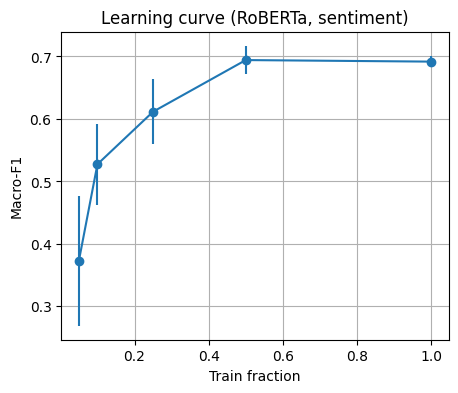

In [ ]:
# ===== Learning curves + seeds for sentiment =====
df = load_yelp_csv()
df = df[["Original Text","Sentiment"]].dropna()
df["Sentiment"] = df["Sentiment"].replace({"Informational":"Mixed"})
keep = ["Mixed","Negative","Positive"]; df = df[df["Sentiment"].isin(keep)]
label2id = {k:i for i,k in enumerate(keep)}; df["y"] = df["Sentiment"].map(label2id)
texts = df["Original Text"].tolist(); labels = df["y"].tolist()
(train_texts, train_labels), (dev_texts, dev_labels), (test_texts, test_labels) = stratified_60_20_20(texts, labels)

sizes = [0.05, 0.10, 0.25, 0.50, 1.00]
seeds = [13, 23, 42]

results = []
for frac in sizes:
    n = max(50, int(len(train_texts)*frac))
    for s in seeds:
        random.seed(s); np.random.seed(s); torch.manual_seed(s)
        idx = np.random.choice(len(train_texts), size=n, replace=False)
        tr_x = [train_texts[i] for i in idx]; tr_y = [train_labels[i] for i in idx]
        # class weights on this subset
        counts = pd.Series(tr_y).value_counts().sort_index().values.astype(np.float32)
        cw = (1.0/counts); cw /= cw.mean()
        tok_ds = make_hf_dataset(tr_x, tr_y, dev_texts, dev_labels, test_texts, test_labels)
        _, (acc, f1m, _, _) = train_roberta_classification(tok_ds, num_labels=len(keep), class_weights=cw, epochs=3)
        results.append({"frac":frac, "seed":s, "acc":acc, "macroF1":f1m})

curve = pd.DataFrame(results).groupby("frac")[["acc","macroF1"]].agg(["mean","std"]).reset_index()
curve.columns = ["frac","acc_mean","acc_std","f1_mean","f1_std"]
print(curve)

plt.figure(figsize=(5,4))
plt.errorbar(curve["frac"], curve["f1_mean"], yerr=curve["f1_std"], marker="o")
plt.xlabel("Train fraction"); plt.ylabel("Macro-F1"); plt.title("Learning curve (RoBERTa, sentiment)")
plt.grid(True); plt.show()


In [ ]:
# ===== Keywords & Summary sanity =====
df = load_yelp_csv()
df = df[["Original Text","Keywords","Summary"]].dropna()

def split_keywords(s):
    if not isinstance(s,str): return []
    return [k.strip().lower() for k in re.split(r"[;,]", s) if k.strip()]

def prec_recall_keywords(row):
    text = row["Original Text"].lower()
    keys = split_keywords(row["Keywords"])
    if not keys: return np.nan, np.nan
    hit = sum(1 for k in keys if k in text)
    prec = hit / len(keys)
    # crude recall proxy: how many top unigrams appear in keywords
    toks = re.findall(r"\w+", text)
    freq = pd.Series(toks).value_counts()
    top = set(freq.head(10).index)
    rec = sum(1 for t in top if any(t in k for k in keys)) / len(top)
    return prec, rec

precisions, recalls = [], []
for _, r in df.iterrows():
    p, rc = prec_recall_keywords(r); precisions.append(p); recalls.append(rc)
print(f"Keywords-in-text precision (mean): {np.nanmean(precisions):.3f}")
print(f"Top-token coverage recall proxy (mean): {np.nanmean(recalls):.3f}")

# Summary compression + similarity (shared vocab TF-IDF)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize

sub = df.sample(min(1000, len(df)), random_state=SEED).copy()

# Fit ONE vectorizer on the union of Original Text + Summary
union_corpus = pd.concat(
    [sub["Original Text"].fillna(""), sub["Summary"].fillna("")],
    ignore_index=True
)
vec = TfidfVectorizer(min_df=2, max_features=20000)
vec.fit(union_corpus)

A = vec.transform(sub["Original Text"].fillna(""))
B = vec.transform(sub["Summary"].fillna(""))

# Row-wise cosine using sparse math (no NxN matrix)
A_n = normalize(A, norm="l2", copy=False)
B_n = normalize(B, norm="l2", copy=False)
sims = np.asarray(A_n.multiply(B_n).sum(axis=1)).ravel()

# Compression ratio
comp = (sub["Summary"].str.len() / sub["Original Text"].str.len()).replace([np.inf, -np.inf], np.nan).fillna(0).clip(upper=5.0)

print(f"Summary cosine(sim) mean: {np.mean(sims):.3f}")
print(f"Compression ratio mean: {np.mean(comp):.3f}")


Keywords-in-text precision (mean): 0.704
Top-token coverage recall proxy (mean): 0.466
Summary cosine(sim) mean: 0.255
Compression ratio mean: 0.116
